Epoch 1/20, Train Loss: 2.0445, Val Acc: 0.6150
Epoch 2/20, Train Loss: 1.0185, Val Acc: 0.7586
Epoch 3/20, Train Loss: 0.6522, Val Acc: 0.8368
Epoch 4/20, Train Loss: 0.4612, Val Acc: 0.8810
Epoch 5/20, Train Loss: 0.3415, Val Acc: 0.9046
Epoch 6/20, Train Loss: 0.2595, Val Acc: 0.9156
Epoch 7/20, Train Loss: 0.2066, Val Acc: 0.9347
Epoch 8/20, Train Loss: 0.1617, Val Acc: 0.9438
Epoch 9/20, Train Loss: 0.1346, Val Acc: 0.9436
Epoch 10/20, Train Loss: 0.1115, Val Acc: 0.9517
Epoch 11/20, Train Loss: 0.1021, Val Acc: 0.9491
Epoch 12/20, Train Loss: 0.0826, Val Acc: 0.9627
Epoch 13/20, Train Loss: 0.0717, Val Acc: 0.9592
Epoch 14/20, Train Loss: 0.0621, Val Acc: 0.9695
Epoch 15/20, Train Loss: 0.0544, Val Acc: 0.9626
Epoch 16/20, Train Loss: 0.0465, Val Acc: 0.9697
Epoch 17/20, Train Loss: 0.0378, Val Acc: 0.9734
Epoch 18/20, Train Loss: 0.0419, Val Acc: 0.9643
Epoch 19/20, Train Loss: 0.0412, Val Acc: 0.9706
Epoch 20/20, Train Loss: 0.0413, Val Acc: 0.9718
Test Accuracy: 0.968777718644

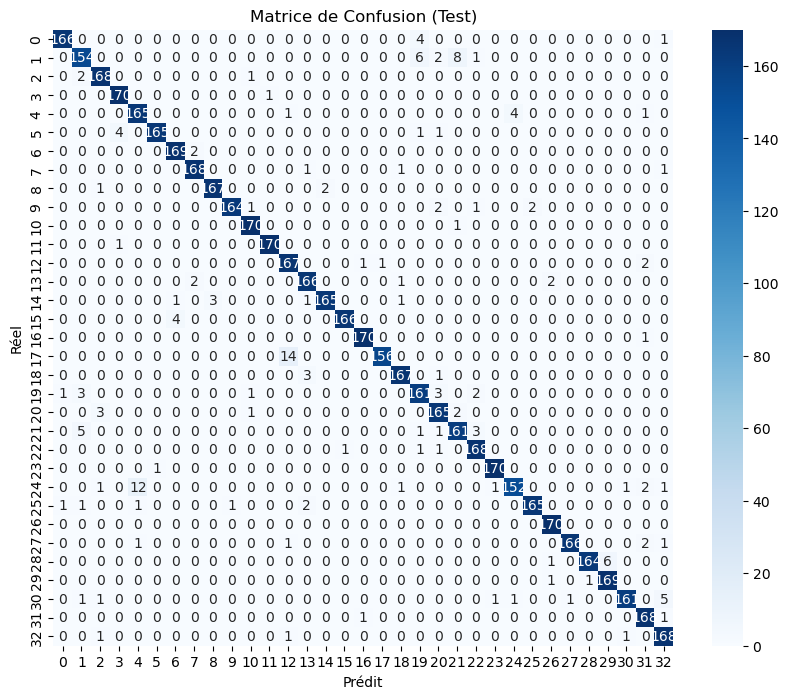

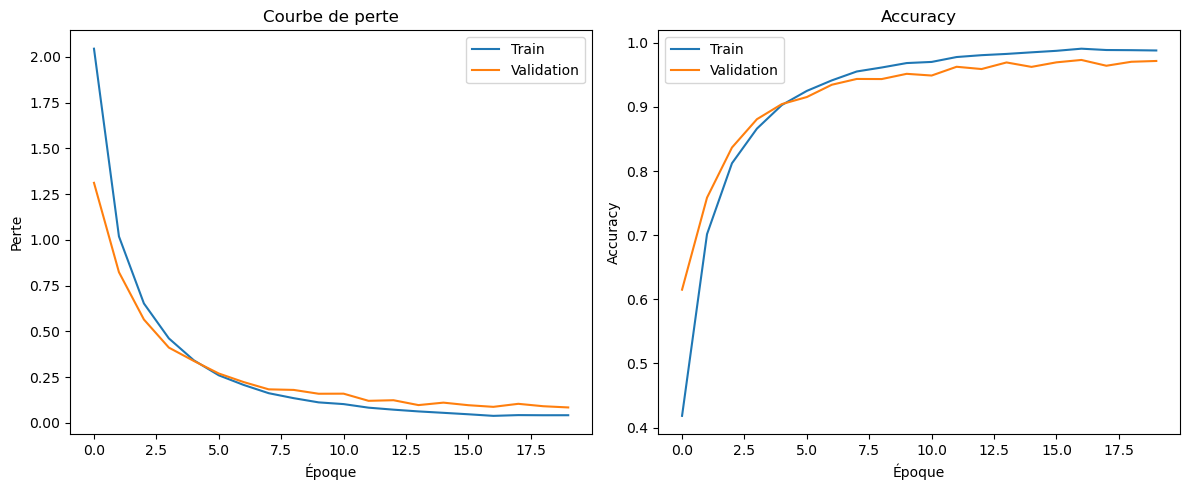

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

# Dataset class
class TifinaghDataset(Dataset):
    def __init__(self, image_paths, labels, root_dir, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_paths[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (32, 32)).astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))
        label = self.labels[idx]
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Dataset preparation
data_dir = r"C:\\Users\\user\\Desktop\\IMSD\\amhcd-data-64\\tifinagh-images"
image_paths, labels = [], []
for label, class_folder in enumerate(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            image_paths.append(os.path.join(class_folder, img_file))
            labels.append(class_folder)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

X_temp, X_test, y_temp, y_test = train_test_split(df['image_path'], df['label_encoded'], test_size=0.2, stratify=df['label_encoded'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

train_dataset = TifinaghDataset(X_train.tolist(), y_train.tolist(), data_dir)
val_dataset = TifinaghDataset(X_val.tolist(), y_val.tolist(), data_dir)
test_dataset = TifinaghDataset(X_test.tolist(), y_test.tolist(), data_dir)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

num_classes = len(label_encoder.classes_)

# Model
class LeNet5(nn.Module):
    def __init__(self, num_classes=33):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / total)
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

# Test
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Test Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion (Test)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# Courbes
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title("Courbe de perte")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title("Accuracy")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


Dataset directory: C:\Users\user\Desktop\IMSD\amhcd-data-64\tifinagh-images
Current working directory: C:\Users\user\Deep learning
Loading dataset from: C:\Users\user\Desktop\IMSD\amhcd-data-64\tifinagh-images
Found 33 classes: ['ya', 'yab', 'yach', 'yad', 'yadd', 'yae', 'yaf', 'yag', 'yagg', 'yagh', 'yah', 'yahh', 'yaj', 'yak', 'yakk', 'yal', 'yam', 'yan', 'yaq', 'yar', 'yarr', 'yas', 'yass', 'yat', 'yatt', 'yaw', 'yax', 'yay', 'yaz', 'yazz', 'yey', 'yi', 'yu']
Class 'ya': 1708 images
Class 'yab': 1708 images
Class 'yach': 1708 images
Class 'yad': 1708 images
Class 'yadd': 1708 images
Class 'yae': 1708 images
Class 'yaf': 1708 images
Class 'yag': 1708 images
Class 'yagg': 1708 images
Class 'yagh': 1708 images
Class 'yah': 1708 images
Class 'yahh': 1708 images
Class 'yaj': 1708 images
Class 'yak': 1708 images
Class 'yakk': 1708 images
Class 'yal': 1708 images
Class 'yam': 1708 images
Class 'yan': 1708 images
Class 'yaq': 1708 images
Class 'yar': 1708 images
Class 'yarr': 1708 images
Cl

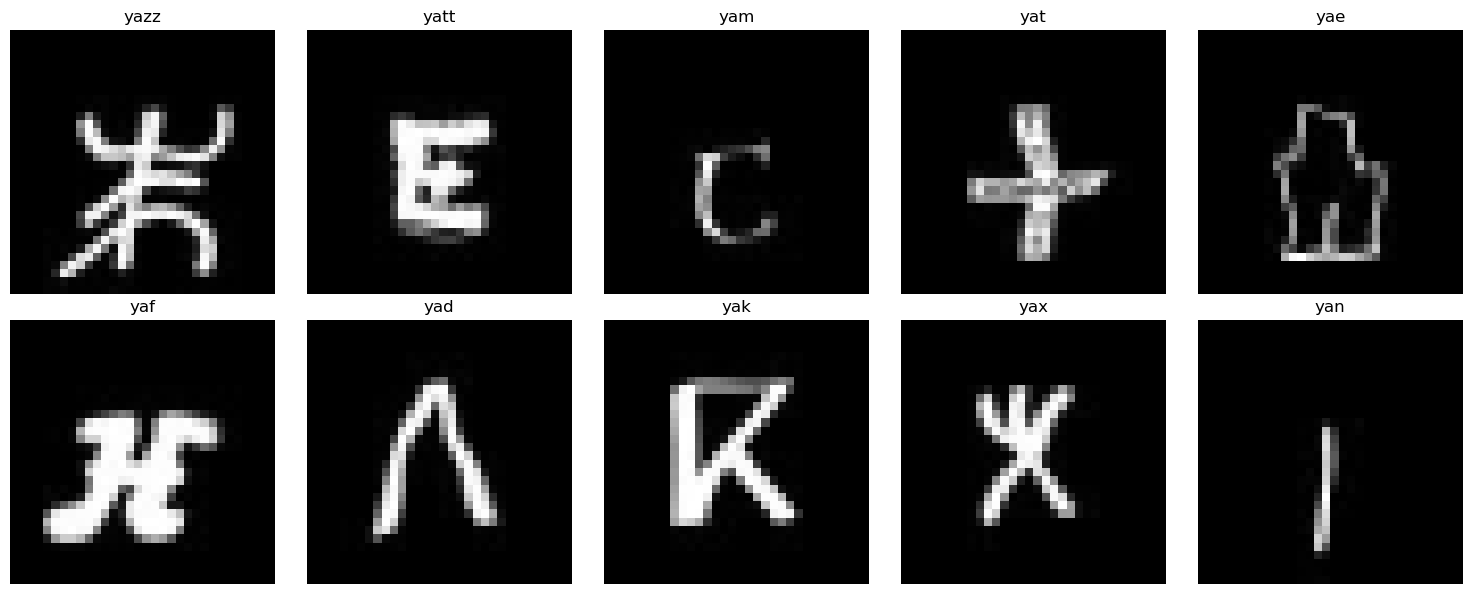


Building LeNet-5 model for 33 classes...

Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                          │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S2 (AveragePooling2D)                │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C3 (Conv2D)                          │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S4 (AveragePooling2D)                │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C5 (Dense)                           │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ F6 (Dense)                           │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 33)                  │           2,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,661 (248.68 KB)

 Trainable params: 63,661 (248.68 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
Epoch 1/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5327 - loss: 1.6952 - val_accuracy: 0.8816 - val_loss: 0.4351 - learning_rate: 0.0010
Epoch 2/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9078 - loss: 0.3373 - val_accuracy: 0.9386 - val_loss: 0.2043 - learning_rate: 0.0010
Epoch 3/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9544 - loss: 0.1604 - val_accuracy: 0.9632 - val_loss: 0.1245 - learning_rate: 0.0010
Epoch 4/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9745 - loss: 0.0916 - val_accuracy: 0.9765 - val_loss: 0.0881 - learning_rate: 0.0010
Epoch 5/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9819 - loss: 0.0661 - val_accuracy: 0.9687 - val_loss: 0.0934 - learning_rate: 0.0010
Epoch 6/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9861 - loss: 0.0487 - val_accuracy: 0.9834 - val_loss: 0.0567 - learning_rate: 0.0010
Epoch 7/50
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/ste

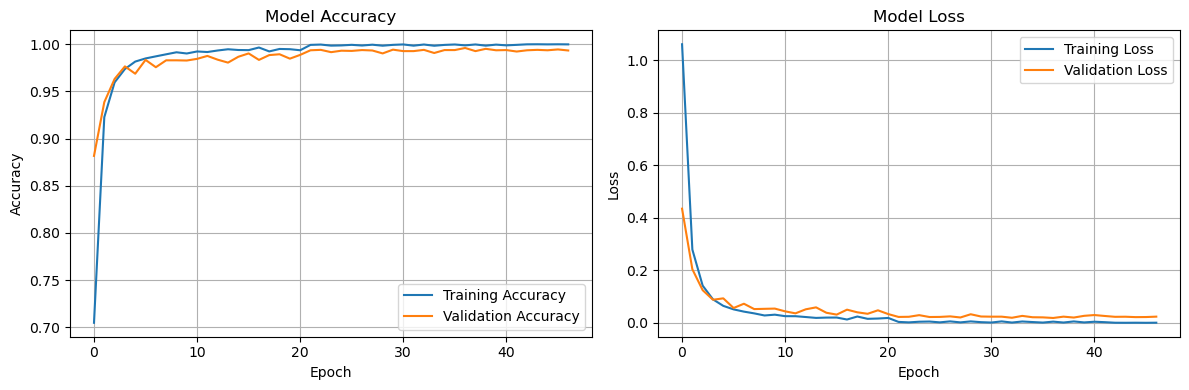


Evaluating on test set...
Test Accuracy: 0.9957
Test Loss: 0.0166

Visualizing convolutional filters...

Visualizing filters for layer: C1


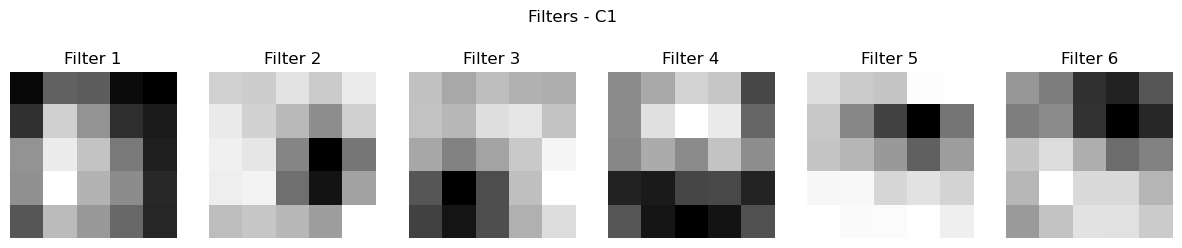


Visualizing filters for layer: C3


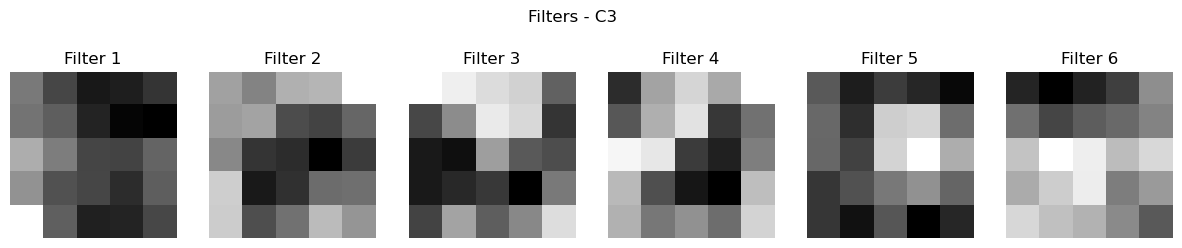


Visualizing layer outputs for test image (class: yaq)...


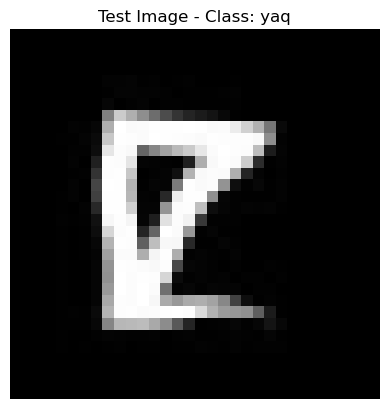

Error during training: The layer sequential_1 has never been called and thus has no defined input.
Please check your dataset structure and file paths.


In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2
from pathlib import Path

class TifinaghDataLoader:
    """Data loader for Tifinagh characters dataset"""

    def __init__(self, data_dir, target_size=(32, 32)):
        self.data_dir = data_dir
        self.target_size = target_size
        self.label_encoder = LabelEncoder()

    def load_dataset(self, test_size=0.2, validation_size=0.1):
        """Load and preprocess the Tifinagh dataset"""
        print(f"Loading dataset from: {self.data_dir}")

        images = []
        labels = []
        class_names = []

        # Get all class directories
        class_dirs = [d for d in os.listdir(self.data_dir)
                     if os.path.isdir(os.path.join(self.data_dir, d))]
        class_dirs.sort()

        print(f"Found {len(class_dirs)} classes: {class_dirs}")

        # Load images from each class
        for class_name in class_dirs:
            class_path = os.path.join(self.data_dir, class_name)
            class_images = []

            # Get all image files in the class directory
            image_files = []
            for ext in ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tiff']:
                image_files.extend(Path(class_path).glob(ext))
                image_files.extend(Path(class_path).glob(ext.upper()))

            print(f"Class '{class_name}': {len(image_files)} images")

            for image_path in image_files:
                try:
                    # Load and preprocess image
                    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
                    if image is not None:
                        # Resize to target size
                        image = cv2.resize(image, self.target_size)
                        # Normalize to [0, 1]
                        image = image.astype(np.float32) / 255.0

                        images.append(image)
                        labels.append(class_name)

                except Exception as e:
                    print(f"Error loading {image_path}: {e}")
                    continue

        if not images:
            raise ValueError("No images found in the dataset!")

        # Convert to numpy arrays
        X = np.array(images)
        y = np.array(labels)

        # Add channel dimension for grayscale images
        X = np.expand_dims(X, axis=-1)

        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)

        print(f"Dataset loaded: {X.shape[0]} images, {len(np.unique(y_encoded))} classes")
        print(f"Image shape: {X.shape[1:]}")

        # Split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=test_size, stratify=y_encoded, random_state=42
        )

        # Split train into train/validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=validation_size, stratify=y_train, random_state=42
        )

        # Convert labels to categorical
        num_classes = len(np.unique(y_encoded))
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_val = keras.utils.to_categorical(y_val, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)

        print(f"Train set: {X_train.shape[0]} samples")
        print(f"Validation set: {X_val.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")

        return (X_train, y_train), (X_val, y_val), (X_test, y_test), num_classes

    def get_class_names(self):
        """Get class names"""
        return self.label_encoder.classes_

    def plot_sample_images(self, X, y, class_names, num_samples=10):
        """Plot sample images from the dataset"""
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.ravel()

        for i in range(min(num_samples, len(X))):
            axes[i].imshow(X[i].squeeze(), cmap='gray')
            class_idx = np.argmax(y[i])
            axes[i].set_title(f'{class_names[class_idx]}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

class LeNet5Model:
    """LeNet-5 CNN Architecture for Tifinagh Character Recognition"""

    def __init__(self, num_classes, input_shape=(32, 32, 1)):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.model = None
        self.history = None

    def build_model(self, activation='tanh'):
        """
        Build LeNet-5 architecture:
        - Input: 32×32 grayscale image
        - C1: 6 filters 5×5 → 28×28×6
        - S2: Average pooling 2×2 → 14×14×6
        - C3: 16 filters 5×5 → 10×10×16
        - S4: Average pooling 2×2 → 5×5×16
        - C5: Fully connected 120 neurons
        - F6: Fully connected 84 neurons
        - Output: num_classes neurons
        """

        model = keras.Sequential([
            # Input layer
            layers.Input(shape=self.input_shape),

            # C1: Convolution layer - 6 filters of 5×5
            layers.Conv2D(6, (5, 5), activation=activation, padding='valid', name='C1'),
            # Output: 28×28×6

            # S2: Average pooling 2×2
            layers.AveragePooling2D((2, 2), strides=2, name='S2'),
            # Output: 14×14×6

            # C3: Convolution layer - 16 filters of 5×5
            layers.Conv2D(16, (5, 5), activation=activation, padding='valid', name='C3'),
            # Output: 10×10×16

            # S4: Average pooling 2×2
            layers.AveragePooling2D((2, 2), strides=2, name='S4'),
            # Output: 5×5×16

            # Flatten for fully connected layers
            layers.Flatten(),

            # C5: Fully connected layer - 120 neurons
            layers.Dense(120, activation=activation, name='C5'),

            # F6: Fully connected layer - 84 neurons
            layers.Dense(84, activation=activation, name='F6'),

            # Output layer - num_classes neurons
            layers.Dense(self.num_classes, activation='softmax', name='Output')
        ])

        self.model = model
        return model

    def compile_model(self, optimizer='adam', learning_rate=0.001):
        """Compile the model"""
        if optimizer == 'adam':
            opt = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
        else:
            opt = optimizer

        self.model.compile(
            optimizer=opt,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        """Train the model"""

        # Callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7
            )
        ]

        # Train the model
        self.history = self.model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def evaluate(self, X_test, y_test):
        """Evaluate the model"""
        return self.model.evaluate(X_test, y_test, verbose=0)

    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X)

    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("No training history available!")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot training & validation accuracy
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        # Plot training & validation loss
        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def save_model(self, filepath):
        """Save the trained model"""
        self.model.save(filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """Load a trained model"""
        self.model = keras.models.load_model(filepath)
        print(f"Model loaded from {filepath}")

    def visualize_filters(self):
        """Visualize convolutional filters"""
        for layer in self.model.layers:
            if isinstance(layer, layers.Conv2D):
                print(f"\nVisualizing filters for layer: {layer.name}")
                filters, biases = layer.get_weights()

                # Normalize filter values to 0-1 for visualization
                f_min, f_max = filters.min(), filters.max()
                filters = (filters - f_min) / (f_max - f_min)

                # Plot first few filters
                n_filters = min(6, filters.shape[3])  # Only show first 6 filters
                fig, axes = plt.subplots(1, n_filters, figsize=(15, 3))

                for i in range(n_filters):
                    ax = axes[i] if n_filters > 1 else axes
                    # Get the filter (for grayscale input, only 1 channel)
                    f = filters[:, :, 0, i]
                    ax.imshow(f, cmap='gray')
                    ax.set_title(f'Filter {i+1}')
                    ax.axis('off')

                plt.suptitle(f'Filters - {layer.name}')
                plt.show()

    def visualize_activations(self, test_image, layer_names=None):
        """Visualize layer activations for a test image"""
        if layer_names is None:
            layer_names = [layer.name for layer in self.model.layers
                          if isinstance(layer, (layers.Conv2D, layers.AveragePooling2D))]

        # Create a model that will return these outputs
        outputs = [self.model.get_layer(name).output for name in layer_names]
        activation_model = keras.models.Model(inputs=self.model.input, outputs=outputs)

        # Get activations
        test_image = np.expand_dims(test_image, axis=0)  # Add batch dimension
        activations = activation_model.predict(test_image)

        # Plot the activations
        for layer_name, layer_activation in zip(layer_names, activations):
            print(f"\nVisualizing outputs for layer: {layer_name}")
            print(f"Activation shape: {layer_activation.shape}")

            # For Conv/Pooling layers
            if len(layer_activation.shape) == 4:
                n_features = min(6, layer_activation.shape[-1])  # Only show first 6 features
                fig, axes = plt.subplots(1, n_features, figsize=(15, 3))

                for i in range(n_features):
                    ax = axes[i] if n_features > 1 else axes
                    ax.imshow(layer_activation[0, :, :, i], cmap='viridis')
                    ax.set_title(f'Feature {i+1}')
                    ax.axis('off')

                plt.suptitle(f'Feature Maps - {layer_name}')
                plt.show()

def main():
    """Main training pipeline"""

    # Dataset configuration
    data_dir = os.path.join(os.getcwd(), r"C:\Users\user\Desktop\IMSD\amhcd-data-64\tifinagh-images")
    print(f"Dataset directory: {data_dir}")
    print(f"Current working directory: {os.getcwd()}")

    # Check if dataset exists
    if not os.path.exists(data_dir):
        print(f"Dataset directory not found: {data_dir}")
        print("Please make sure the dataset is in the correct location.")
        return

    # Load dataset
    data_loader = TifinaghDataLoader(data_dir, target_size=(32, 32))

    try:
        (X_train, y_train), (X_val, y_val), (X_test, y_test), num_classes = data_loader.load_dataset()
        class_names = data_loader.get_class_names()

        print(f"\nDataset Summary:")
        print(f"Number of classes: {num_classes}")
        print(f"Class names: {class_names}")

        # Plot sample images
        print("\nDisplaying sample images...")
        data_loader.plot_sample_images(X_train, y_train, class_names)

        # Create and build model
        print(f"\nBuilding LeNet-5 model for {num_classes} classes...")
        lenet = LeNet5Model(num_classes=num_classes)

        # Build with tanh activation (original LeNet-5)
        model = lenet.build_model(activation='tanh')

        # Print model architecture
        print("\nModel Architecture:")
        model.summary()

        # Compile model
        lenet.compile_model(optimizer='adam', learning_rate=0.001)

        # Train model
        print("\nStarting training...")
        history = lenet.train(
            X_train, y_train,
            X_val, y_val,
            epochs=50,
            batch_size=32
        )

        # Plot training history
        lenet.plot_training_history()

        # Evaluate on test set
        print("\nEvaluating on test set...")
        test_loss, test_accuracy = lenet.evaluate(X_test, y_test)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")

        # Visualize convolutional filters
        print("\nVisualizing convolutional filters...")
        lenet.visualize_filters()

        # Visualize layer activations for a test image
        test_sample_idx = 0  # You can change this index
        test_image = X_test[test_sample_idx]
        true_label = class_names[np.argmax(y_test[test_sample_idx])]

        print(f"\nVisualizing layer outputs for test image (class: {true_label})...")
        plt.imshow(test_image.squeeze(), cmap='gray')
        plt.title(f"Test Image - Class: {true_label}")
        plt.axis('off')
        plt.show()

        # Visualize activations for all conv/pool layers
        lenet.visualize_activations(test_image)

        # You can also specify particular layers
        # lenet.visualize_activations(test_image, layer_names=['C1', 'S2', 'C3', 'S4'])

        # Save model
        model_path = 'lenet5_tifinagh_model.h5'
        lenet.save_model(model_path)

        # Make predictions on test set
        print("\nMaking predictions on test samples...")
        predictions = lenet.predict(X_test[:10])

        # Show predictions
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.ravel()

        for i in range(10):
            axes[i].imshow(X_test[i].squeeze(), cmap='gray')
            pred_class = np.argmax(predictions[i])
            true_class = np.argmax(y_test[i])

            title = f'Pred: {class_names[pred_class]}\nTrue: {class_names[true_class]}'
            color = 'green' if pred_class == true_class else 'red'
            axes[i].set_title(title, color=color)
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\nTraining completed successfully!")
        print(f"Model saved as: {model_path}")

    except Exception as e:
        print(f"Error during training: {e}")
        print("Please check your dataset structure and file paths.")

if __name__ == "__main__":
    main()

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

# Dataset class
class TifinaghDataset(Dataset):
    def _init_(self, image_paths, labels, root_dir, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def _len_(self):
        return len(self.image_paths)

    def _getitem_(self, idx):
        img_path = os.path.join(self.root_dir, self.image_paths[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (32, 32)).astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))
        label = self.labels[idx]
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Dataset preparation
data_dir =r"C:\Users\user\Desktop\IMSD\amhcd-data-64\tifinagh-images"
image_paths, labels = [], []

# Vérifier si le répertoire existe
if not os.path.exists(data_dir):
    print(f"Erreur: Le répertoire {data_dir} n'existe pas.")
    exit()

for label, class_folder in enumerate(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrer les images
                image_paths.append(os.path.join(class_folder, img_file))
                labels.append(class_folder)

if len(image_paths) == 0:
    print("Aucune image trouvée dans le répertoire.")
    exit()

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

print(f"Nombre total d'images: {len(df)}")
print(f"Nombre de classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

# Split des données
X_temp, X_test, y_temp, y_test = train_test_split(
    df['image_path'], df['label_encoded'], 
    test_size=0.2, stratify=df['label_encoded'], random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.25, stratify=y_temp, random_state=42
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# Création des datasets
train_dataset = TifinaghDataset(X_train.tolist(), y_train.tolist(), data_dir)
val_dataset = TifinaghDataset(X_val.tolist(), y_val.tolist(), data_dir)
test_dataset = TifinaghDataset(X_test.tolist(), y_test.tolist(), data_dir)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

num_classes = len(label_encoder.classes_)

# Model LeNet5
class LeNet5(nn.Module):
    def _init_(self, num_classes=33):
        super(LeNet5, self)._init_()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé: {device}")

model = LeNet5(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("Début de l'entraînement...")

for epoch in range(epochs):
    # Phase d'entraînement
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistiques
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # Phase de validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / total)
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"Val Acc: {val_accs[-1]:.4f}")

# Évaluation sur le test set
print("\nÉvaluation sur le test set...")
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

test_accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nRapport de classification:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Visualisation de la matrice de confusion
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title("Matrice de Confusion (Test Set)")
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Courbes d'apprentissage
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Validation', marker='s')
plt.title("Courbe de Perte")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, label='Train', marker='o')
plt.plot(range(1, epochs+1), val_accs, label='Validation', marker='s')
plt.title("Courbe d'Accuracy")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(range(1, epochs+1), np.array(train_accs) - np.array(val_accs), 
         label='Écart Train-Val', marker='d', color='red')
plt.title("Écart Train-Validation")
plt.xlabel("Époque")
plt.ylabel("Différence d'Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Sauvegarde du modèle
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'num_classes': num_classes,
    'test_accuracy': test_accuracy
}, 'tifinagh_lenet5_model.pth')

print("\nModèle sauvegardé dans 'tifinagh_lenet5_model.pth'")

Nombre total d'images: 28182
Nombre de classes: 33
Classes: ['ya' 'yab' 'yach' 'yad' 'yadd' 'yae' 'yaf' 'yag' 'yagg' 'yagh' 'yah'
 'yahh' 'yaj' 'yak' 'yakk' 'yal' 'yam' 'yan' 'yaq' 'yar' 'yarr' 'yas'
 'yass' 'yat' 'yatt' 'yaw' 'yax' 'yay' 'yaz' 'yazz' 'yey' 'yi' 'yu']
Train: 16908, Val: 5637, Test: 5637


TypeError: TifinaghDataset() takes no arguments